In [1]:
import pandas as pd
from rugby import *
import matplotlib.pyplot as plt

/home/daniel/repositories/rugby-data/notebooks/rugby/__init__.py:60: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  and (score.type is not "conversion")
/home/daniel/repositories/rugby-data/notebooks/rugby/__init__.py:63: SyntaxWarning: "is" with a literal. Did you mean "=="?
  and (score.type is "conversion")


In [2]:
import pymc as pm

In [3]:
import arviz as az
import numpy as np
import scipy.stats as st

In [51]:
data = pd.read_json("../json/celtic-2016-2017.json")

In [57]:
data = pd.read_json("../json/celtic-2016-2017.json")
pro14_2016 = Tournament("URC", "2016-2017", data)

[67, 0] [80]


In [58]:
data = pd.read_json("../json/celtic-2017-2018.json")
pro14_2017 = Tournament("URC", "2017-2018", data)

[47, 0] [80]
[64, 0] [80]
[59, 0] [80]
[71, 0] [80]
[50, 0] [80]
[56, 0] [80]
[73, 0] [80]
[59, 0] [80]
[55, 0] [80]
[48, 0] [80]
[55, 0] [80]
[59, 0] [80]
[68, 0] [80]
[50, 0] [80]
[64, 0] [80]
[69, 0] [80]
[52, 0] [80]
[52, 0] [80]
[66, 0] [80]


In [59]:
team = pro14.teams()[-3] # Glasgow

In [60]:
team

Glasgow

In [55]:
all_attack = {player.name: player.total_on_field_points(pro14)/player.total_play_time(pro14)/15 for player in pro14.players() if player.total_play_time(pro14)>50}

Text(0.5, 0, 'Scoring coefficient / points per minute per player')

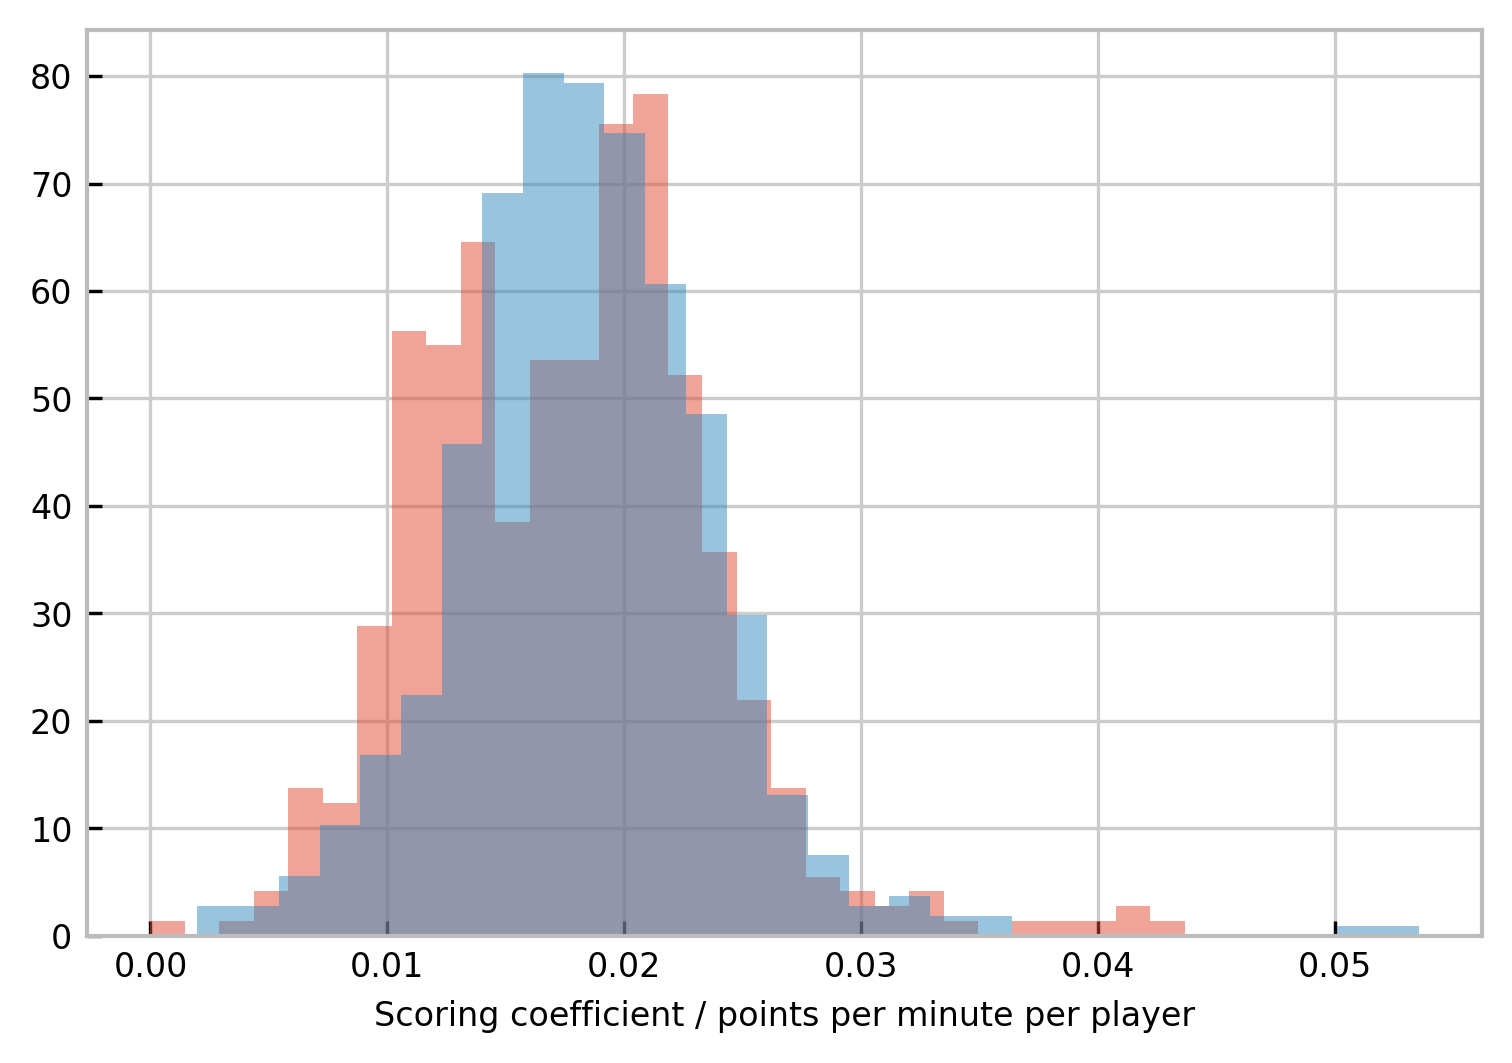

In [61]:
f, ax = plt.subplots(1,1, dpi=300)
pro14 = pro14_2016
all_attack = {player.name: player.total_on_field_points(pro14)/player.total_play_time(pro14)/15 for player in pro14.players() if player.total_play_time(pro14)>50}
ax.hist(all_attack.values(), bins=30, density=True, alpha=0.5);
pro14 = pro14_2017
all_attack = {player.name: player.total_on_field_points(pro14)/player.total_play_time(pro14)/15 for player in pro14.players() if player.total_play_time(pro14)>50}
ax.hist(all_attack.values(), bins=30, density=True, alpha=0.5);
ax.set_xlabel("Scoring coefficient / points per minute per player")

In [10]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    mu_prior = pm.Normal("mu", mu=0.02, sigma=0.01)
    sigma_prior = pm.Normal("sigma", mu=0, sigma=0.01)


    # Likelihood (sampling distribution) of observations
    attack_obs = pm.TruncatedNormal("Y_obs", 
                               mu=mu_prior, sigma=sigma_prior, 
                               lower=0,
                               observed=list(all_attack.values()))

In [11]:
with basic_model:
    # draw 1000 posterior samples
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


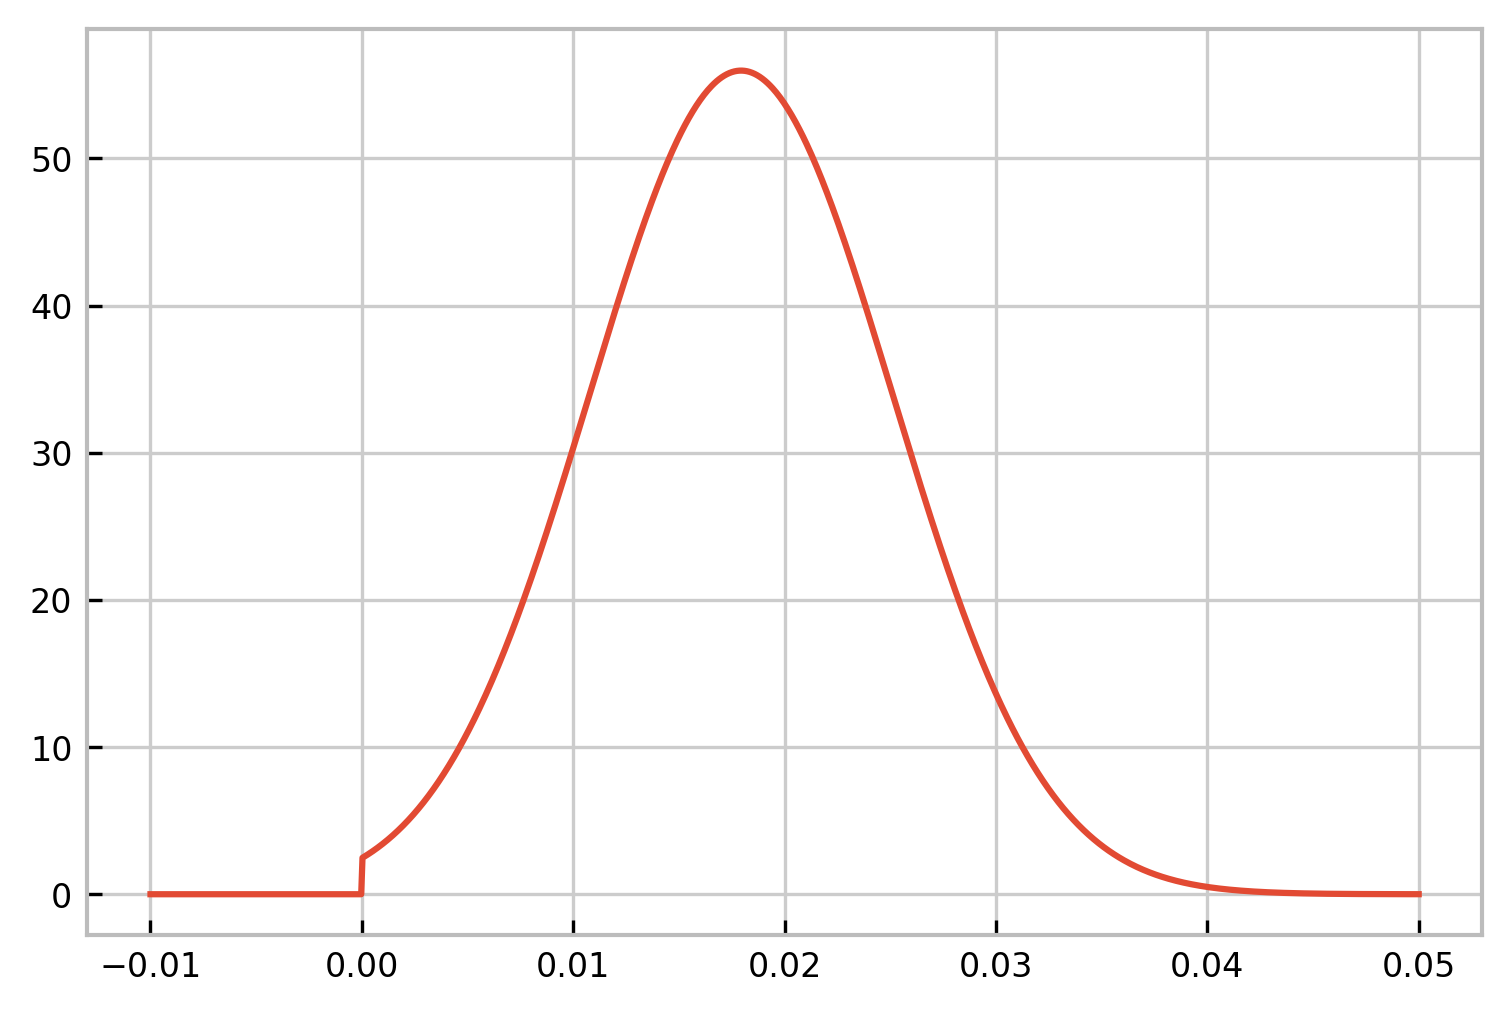

In [12]:
f, ax = plt.subplots(1,1, dpi=300)
x = np.linspace(-0.01, 0.05, 1000)
mu = idata.posterior['mu'].max()
sigma = idata.posterior['sigma'].max()
pdf = st.truncnorm.pdf(x, a=(0-mu)/sigma, b=np.infty, loc=mu, scale=sigma)
ax.plot(x, pdf, label=r'$\mu$ = {}, $\sigma$ = {}'.format(mu, sigma))

In [13]:
players = team.squad(pro14)
glasgow_attack_perc = {player.name: st.truncnorm.cdf(player.total_on_field_points(pro14)/player.total_play_time(pro14)/15, a=(0-mu)/sigma, b=np.infty, loc=mu, scale=sigma)
                              for player in players if player.total_play_time(pro14)>50}
glasgow_attack = {player.name: player.total_on_field_points(pro14)/player.total_play_time(pro14)/15
                              for player in players if player.total_play_time(pro14)>50}

findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans.


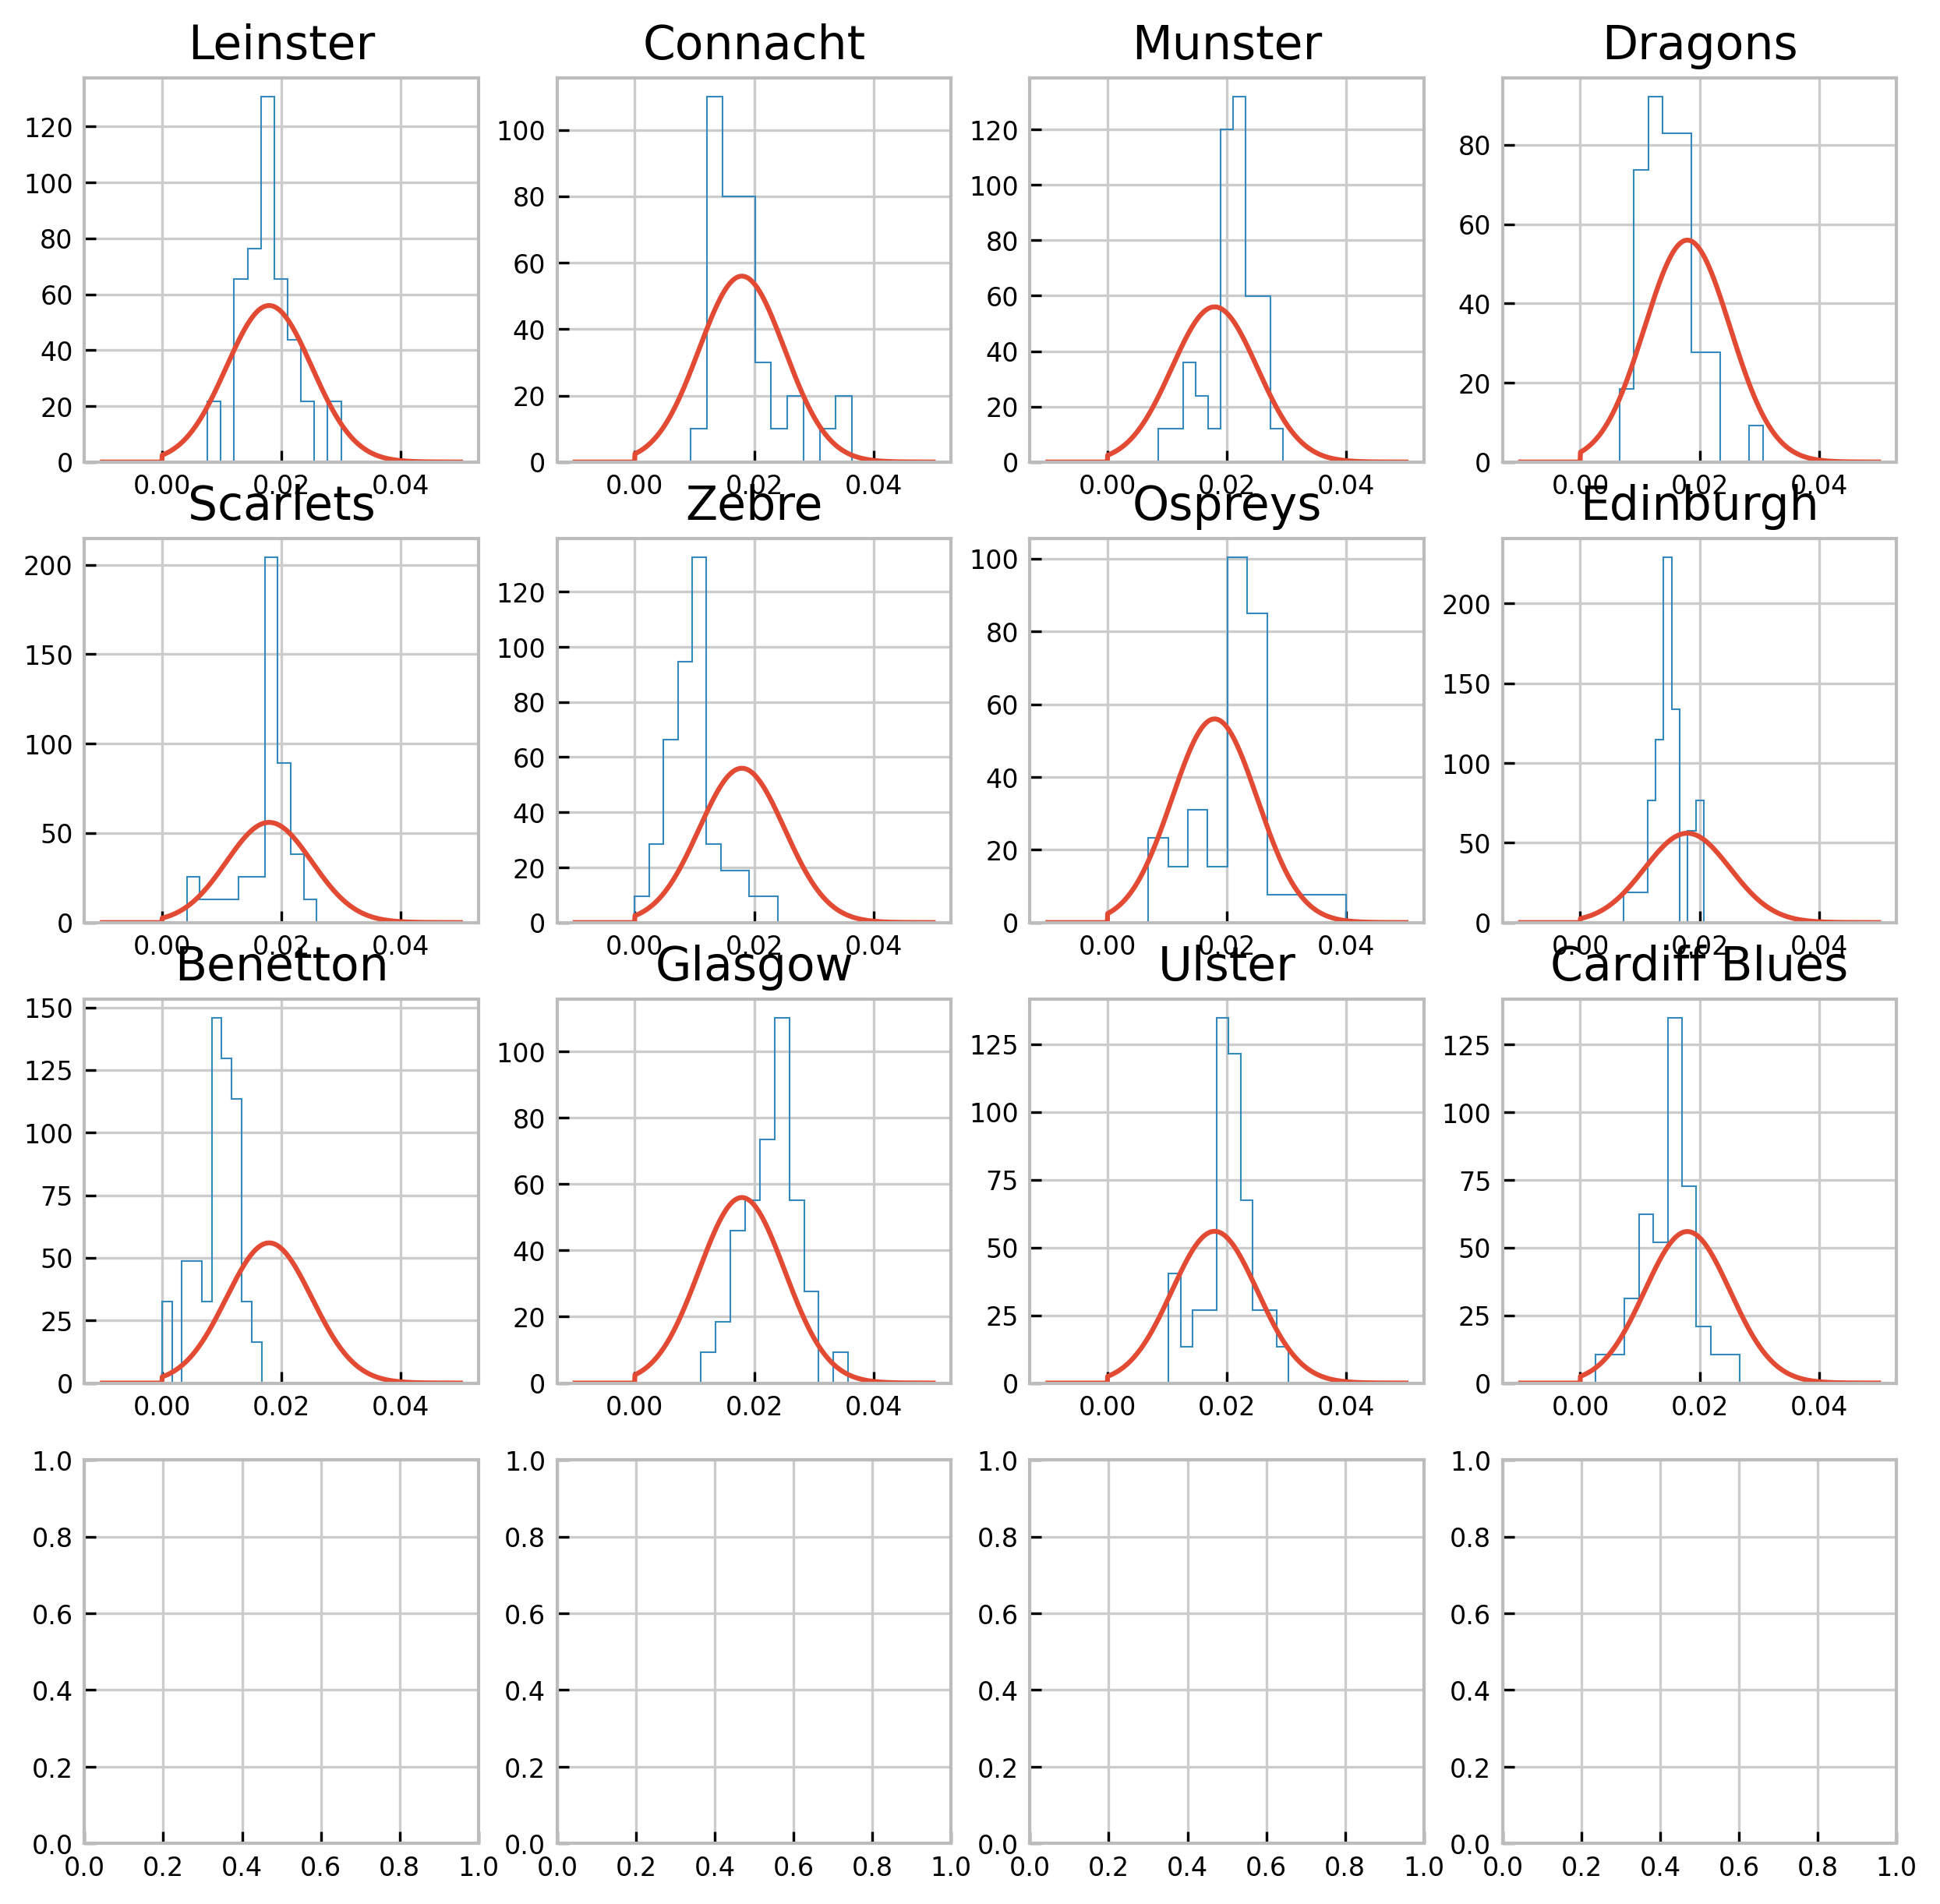

In [14]:
f, axes = plt.subplots(4,4, dpi=300, figsize=(10,10))
x = np.linspace(-0.01, 0.05, 1000)
mu = idata.posterior['mu'].max()
sigma = idata.posterior['sigma'].max()
pdf = st.truncnorm.pdf(x, a=(0-mu)/sigma, b=np.infty, loc=mu, scale=sigma)
#ax.set_xlabel("Scoring coefficient / points per minute per player")


for team, ax in zip(pro14.teams(), axes.flatten()):
    ax.plot(x, pdf, label=f"League distribution")
    players = team.squad(pro14)
    glasgow_attack_perc = {player.name: st.truncnorm.cdf(player.total_on_field_points(pro14)/player.total_play_time(pro14)/15, a=(0-mu)/sigma, b=np.infty, loc=mu, scale=sigma)
                                  for player in players if player.total_play_time(pro14)>50}
    glasgow_attack = {player.name: player.total_on_field_points(pro14)/player.total_play_time(pro14)/15
                                  for player in players if player.total_play_time(pro14)>50}
    ax.set_title(f"{team}")
    ax.hist(glasgow_attack.values(), density=True, label=f"{team} distribution", histtype="step");
    #ax.legend()

In [15]:
all_defence = {player.name: player.total_on_field_concession(pro14)/player.total_play_time(pro14)/15 for player in pro14.players() if player.total_play_time(pro14)>50}

Text(0.5, 0, 'Concession coefficient / points per minute per player')

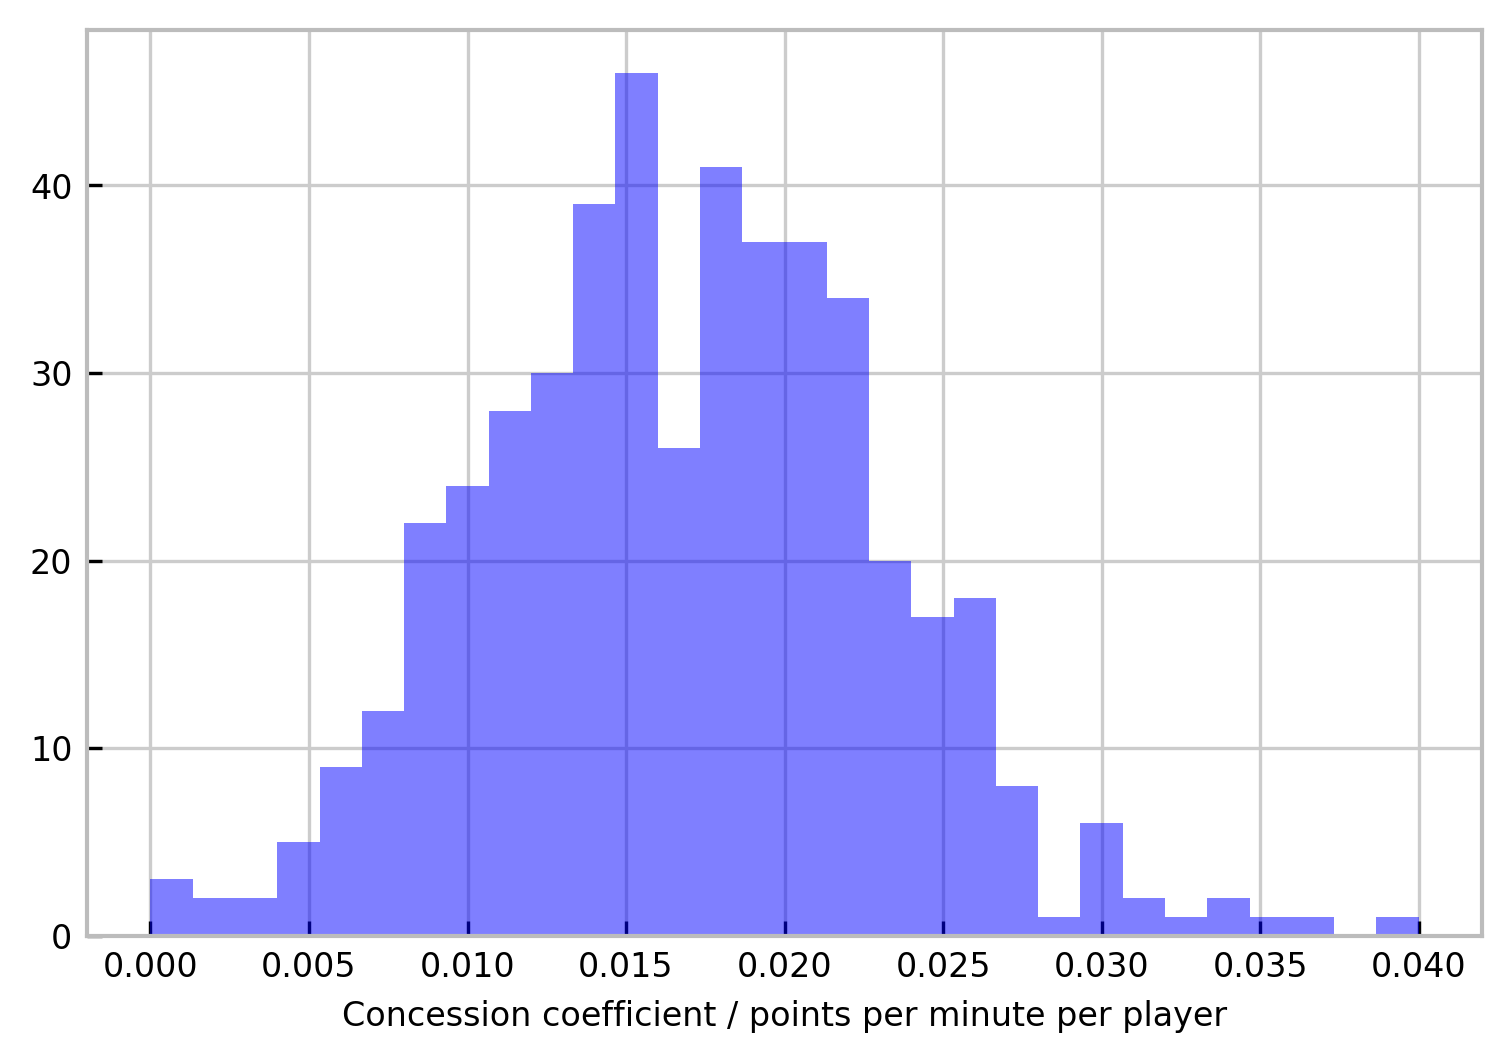

In [16]:
f, ax = plt.subplots(1,1, dpi=300)
ax.hist(all_attack.values(), bins=30, alpha=0.5, color='blue');
ax.set_xlabel("Concession coefficient / points per minute per player")

In [17]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    mu_prior = pm.Normal("mu", mu=0.02, sigma=0.01)
    sigma_prior = pm.Normal("sigma", mu=0, sigma=0.01)


    # Likelihood (sampling distribution) of observations
    defence_obs = pm.TruncatedNormal("Y_obs", 
                               mu=mu_prior, sigma=sigma_prior, 
                               lower=0,
                               observed=list(all_defence.values()))

In [18]:
with basic_model:
    # draw 1000 posterior samples
    idata_def = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


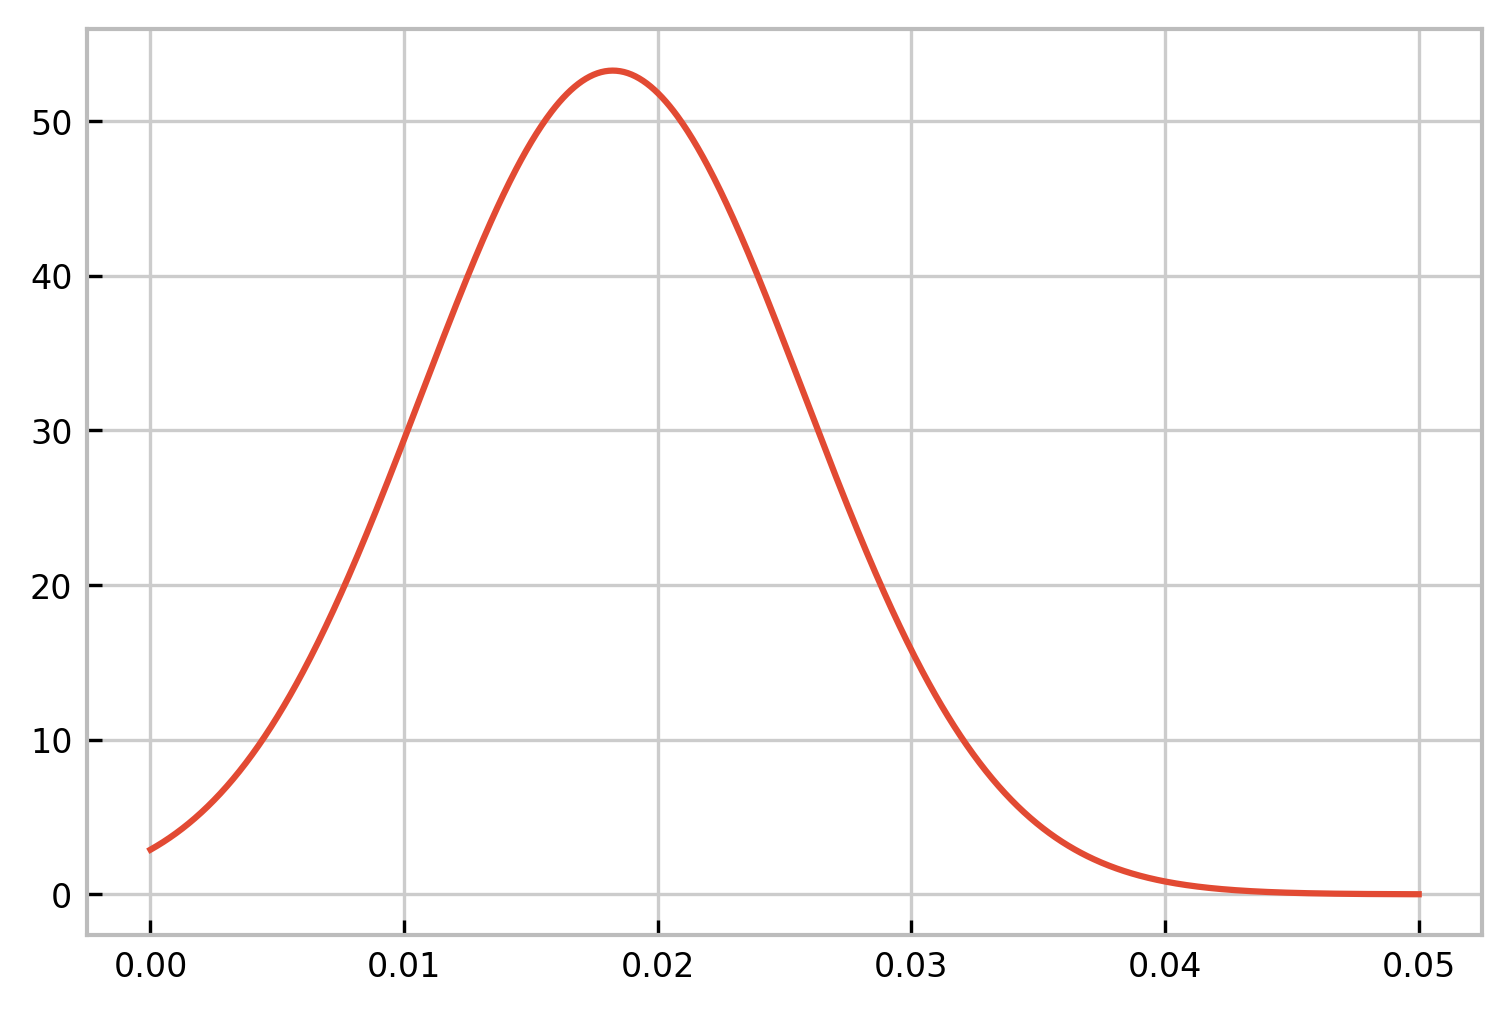

In [19]:
f, ax = plt.subplots(1,1, dpi=300)
x = np.linspace(-0.0, 0.05, 1000)
mu_def = idata_def.posterior['mu'].max()
sigma_def = idata_def.posterior['sigma'].max()
pdf = st.truncnorm.pdf(x, a=(0-mu_def)/sigma_def, b=np.infty, loc=mu_def, scale=sigma_def)
ax.plot(x, pdf, label=r'$\mu$ = {}, $\sigma$ = {}'.format(mu_def, sigma_def))

In [20]:
players = team.squad(pro14)
glasgow_defence = {player.name: (st.truncnorm.cdf(player.total_on_field_points(pro14)/player.total_play_time(pro14)/15, 
                                                a=(0-mu_def)/sigma_def, b=np.infty, loc=mu_def, scale=sigma_def))
                              for player in players if player.total_play_time(pro14)>50}

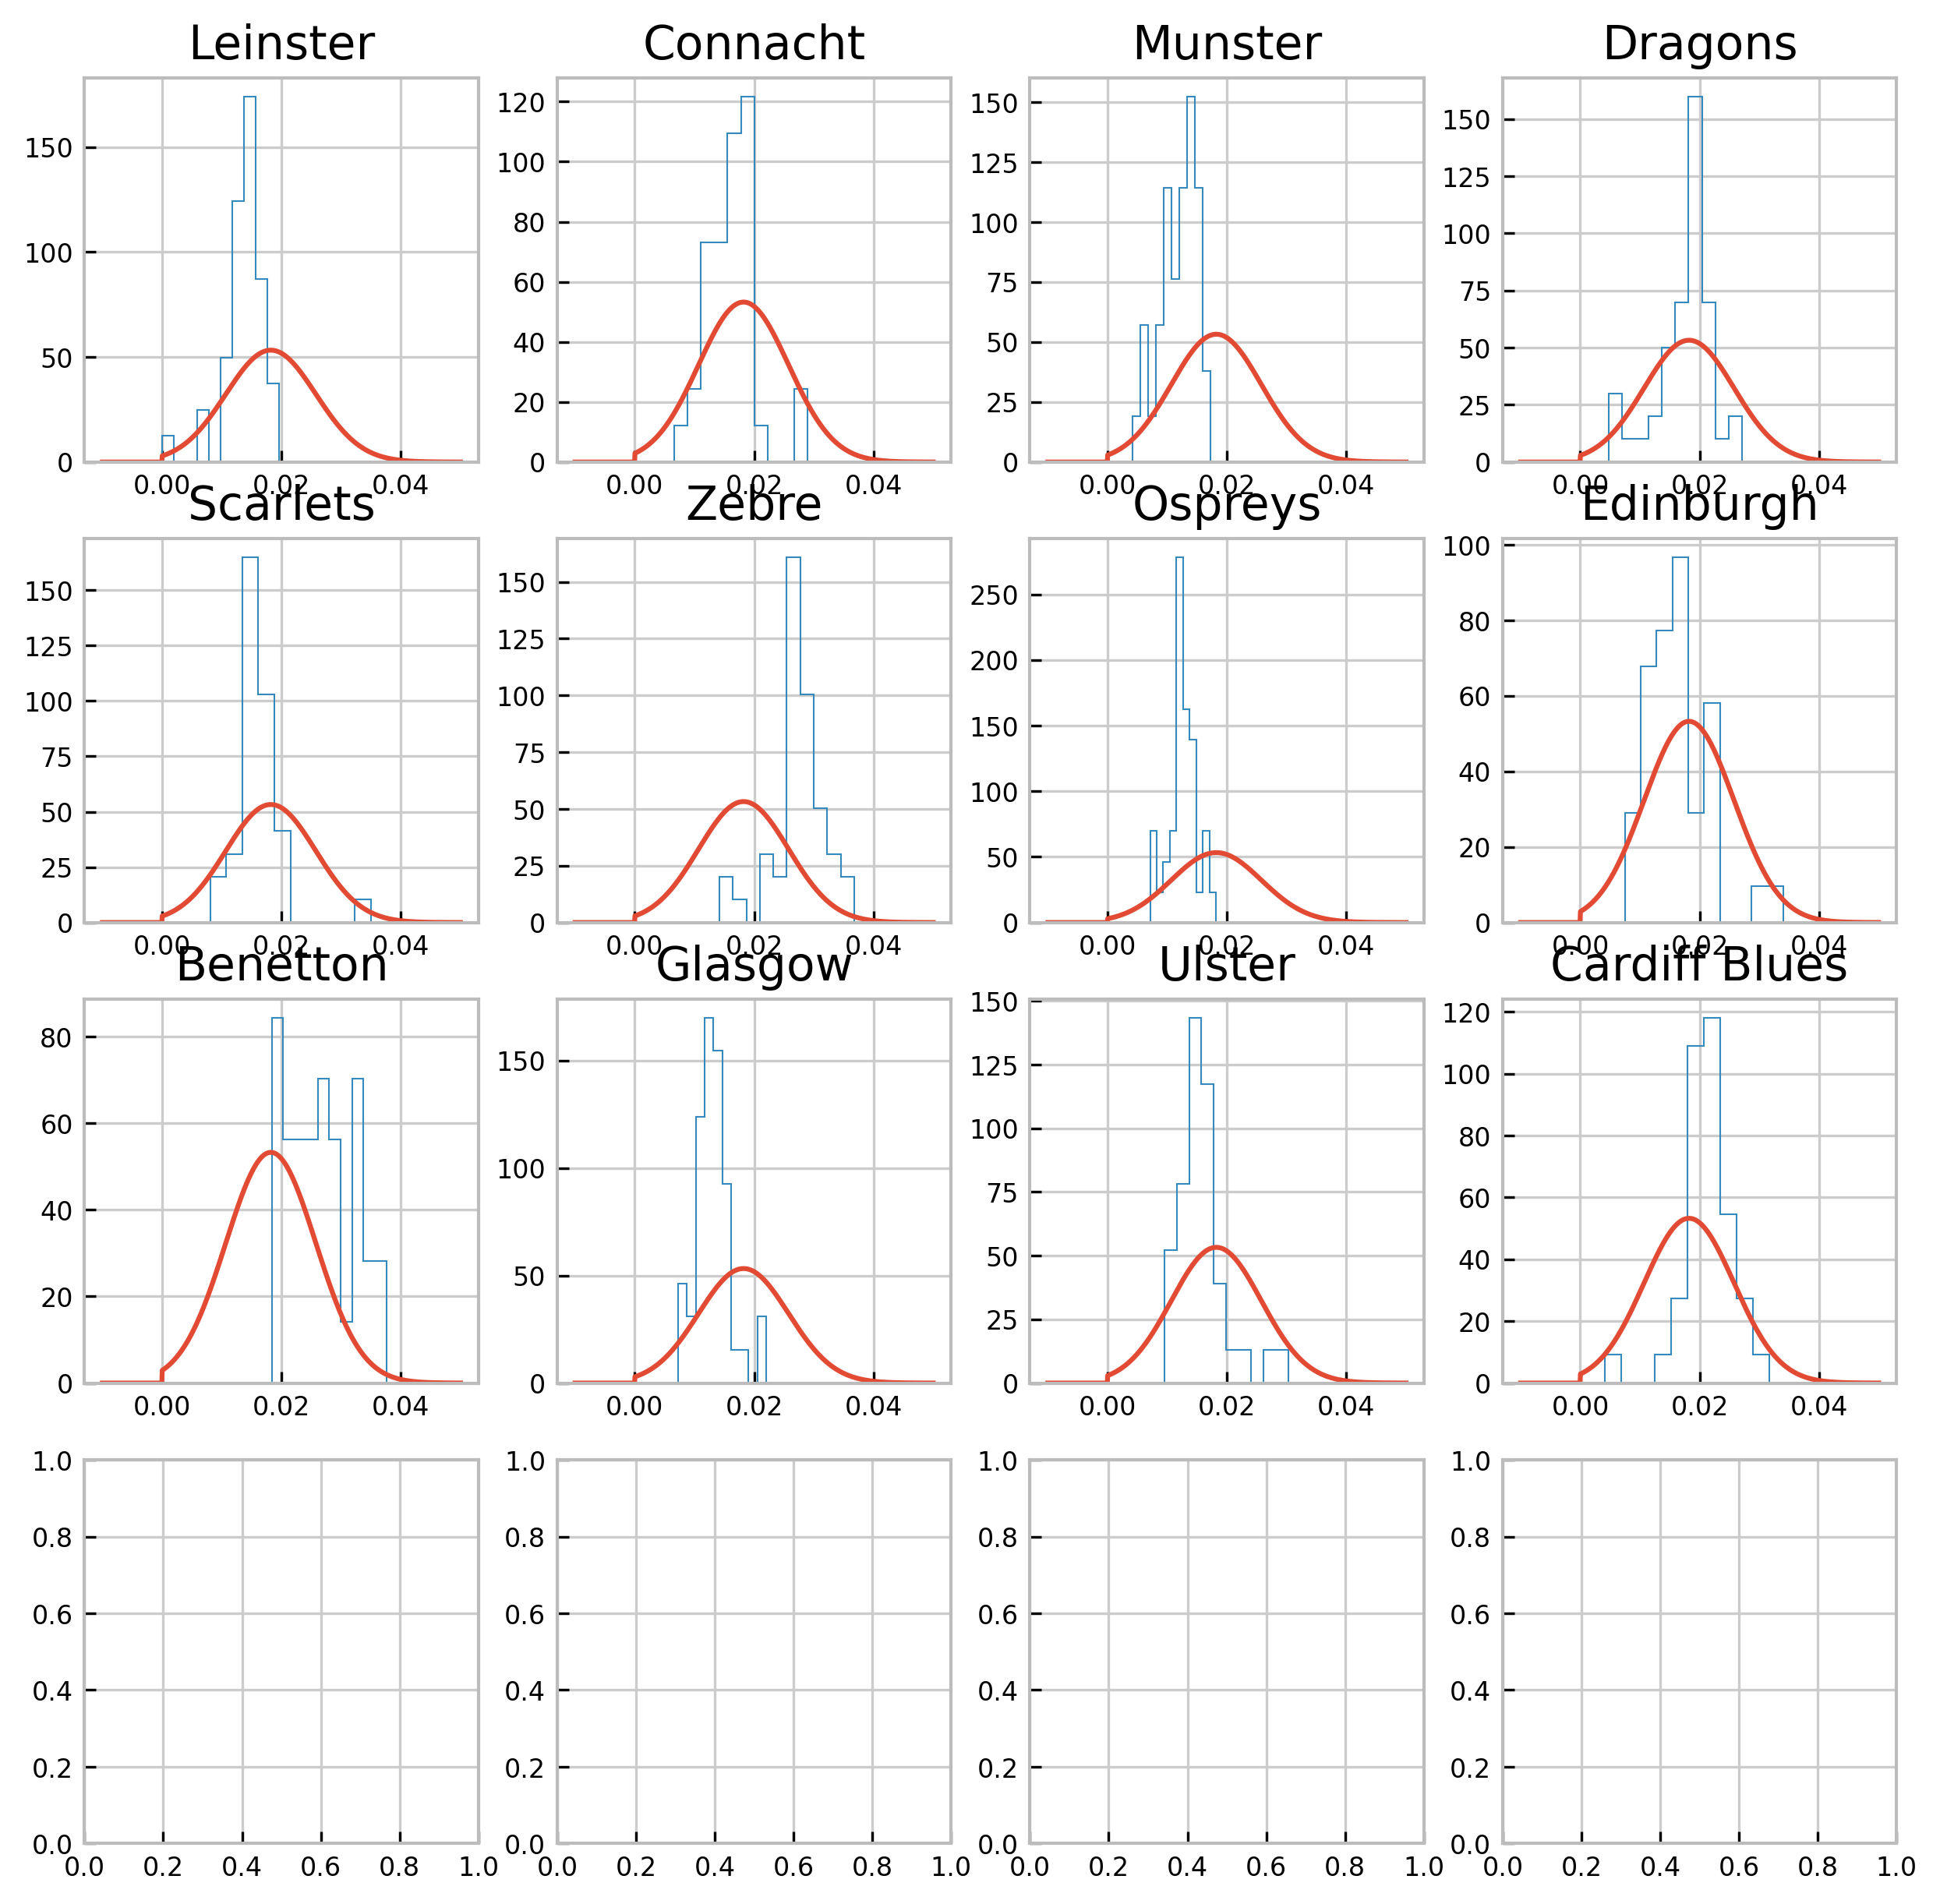

In [22]:
f, axes = plt.subplots(4,4, dpi=300, figsize=(10,10))
x = np.linspace(-0.01, 0.05, 1000)
mu = idata_def.posterior['mu'].max()
sigma = idata_def.posterior['sigma'].max()
pdf = st.truncnorm.pdf(x, a=(0-mu)/sigma, b=np.infty, loc=mu, scale=sigma)
#ax.set_xlabel("Scoring coefficient / points per minute per player")


for team, ax in zip(pro14.teams(), axes.flatten()):
    ax.plot(x, pdf, label=f"League distribution")
    players = team.squad(pro14)
    glasgow_def_perc = {player.name: st.truncnorm.cdf(player.total_on_field_concession(pro14)/player.total_play_time(pro14)/15, a=(0-mu)/sigma, b=np.infty, loc=mu, scale=sigma)
                                  for player in players if player.total_play_time(pro14)>50}
    glasgow_attack = {player.name: player.total_on_field_concession(pro14)/player.total_play_time(pro14)/15
                                  for player in players if player.total_play_time(pro14)>50}
    ax.set_title(f"{team}")
    ax.hist(glasgow_attack.values(), density=True, label=f"{team} distribution", histtype="step");
    #ax.legend()